# Machine Learning Model Training - Markus Parrish

Goals:

Session 16 provides parametrizable CNN models that you can train. Experiment with a few (at least three) CNN models and the Linear model for the given classification problem.

Deliverables:

1. A PDF of the Python code used to generate the different models. Use the provided code to print the architectures and the number of parameters.
2. Screenshots of the achieved accuracy as a function of the number of epochs and the value of the loss function.
3. A discussion comparing the required number of epochs, total number of parameters, final value of the loss function, and achieved accuracy.


References:
* A collection of tutorials are available at [main website](https://docs.pytorch.org/tutorials/).
* The current document follows the [Quickstart tutorial](https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

Discussion
===============

There is a distinct trend that the increase in number of epochs correlates to a higher accuracy and lower loss function values; however, a plateau occurs as the number increases (shown in plots below). Each of the models was set at 5 epochs as a baseline. For the CNN models, increasing the model capacity resulted in a increase in accuracy. However, the linear model did achieve the highest accuracy. Additionally, parameter count increases as the number of filters are applied - resulting in an increase in accuarcy and greater efficiency comapred to the linear model.
### Parameter counts
1. Linear Model: 669,706
2. CNN Model Simple (4,8): 4,266
3. CNN Model 2 (8,16): 9,098
4. CNN Model 3 (16,32): 20,490


### Model accuracy & loss



1. Linear Model: Accuracy: 65.1%, Avg loss: 1.071164
2. CNN Model Simple (4,8): Accuracy: 49.8%, Avg loss: 1.462805
3. CNN Model 2 (8,16): Accuracy: 50.9%, Avg loss: 1.519687
4. CNN Model 3 (16,32): Accuracy: 62.9%, Avg loss: 1.151470




# Setup

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
import math
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

# Datasets

<b>TorchVision dataset used for this assignment</b><br>



In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

<b>Dataloader</b><br>
Pass `Dataset` as an argument to `DataLoader`.


In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print("N = batch size. This is the number of images to process at a time.")
    print("C = number of channels. C=1 for grayscale. C=3 for RGB.")
    print("H = height is the number of rows in the image.")
    print("W = width is the number of columns in the image.")
    print(" ")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print("y is of size N, the ground truth labels required for each image in the batch.")
    break

train_size = len(train_dataloader.dataset)
test_size  = len(test_dataloader.dataset)
train_pct  = 100*train_size/(train_size+test_size)
test_pct   = 100*test_size/(train_size+test_size)
print(f"Percentage of training dataset = {train_pct:.2f} percent with {train_size} samples.")
print(f"Percentage of test dataset     = {test_pct:.2f} percent with {test_size} samples.")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
N = batch size. This is the number of images to process at a time.
C = number of channels. C=1 for grayscale. C=3 for RGB.
H = height is the number of rows in the image.
W = width is the number of columns in the image.
 
Shape of y: torch.Size([64]) torch.int64
y is of size N, the ground truth labels required for each image in the batch.
Percentage of training dataset = 85.71 percent with 60000 samples.
Percentage of test dataset     = 14.29 percent with 10000 samples.


Linear Model
===============

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Define the model here

## Linear Model
NeuralNetwork = LinearModel
model_to_use  = LinearModel()

model = model_to_use.to(device)
print(f"Using Model: {model.__class__.__name__}") # Name of model print

Using cpu device
Using Model: LinearModel


## Model Parameters

In [ ]:
def parameter_report(model):
    print(f"{'Layer':<40} {'# Params':>12} {'Trainable':>10}")
    print("-" * 65)
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        is_trainable = param.requires_grad
        print(f"{name:<40} {num_params:>12,} {str(is_trainable):>10}")
        total += num_params
        if is_trainable:
            trainable += num_params
    print("-" * 65)
    print(f"{'Total':<40} {total:>12,} {'':>10}")
    print(f"{'Trainable':<40} {trainable:>12,}")


print(model)
print(" ")

parameter_report(model)

LinearModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
 
Layer                                        # Params  Trainable
-----------------------------------------------------------------
linear_relu_stack.0.weight                    401,408       True
linear_relu_stack.0.bias                          512       True
linear_relu_stack.2.weight                    262,144       True
linear_relu_stack.2.bias                          512       True
linear_relu_stack.4.weight                      5,120       True
linear_relu_stack.4.bias                           10       True
-----------------------------------------------------------------
Total                                         669,706           
Trainable                    

------------------------------------------------------------------------


## Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Training function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Put the model in training mode.
    for batch, (X, y) in enumerate(dataloader):
        # Place the model and predictions on the same device.
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        # This step updates the parameter values inside your network.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress every 100 batches:
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Testing function

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in testing mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

## Linear Model: Accuracy, Epochs, and Value of Loss Function

In [ ]:
epochs = 5 # Number of epochs
accuracy_h = []
loss_h =[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    epoch_accuracy, epoch_loss = test(test_dataloader, model, loss_fn)
    accuracy_h.append(epoch_accuracy)
    loss_h.append(epoch_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306733  [   64/60000]
loss: 2.292386  [ 6464/60000]
loss: 2.268327  [12864/60000]
loss: 2.264663  [19264/60000]
loss: 2.253597  [25664/60000]
loss: 2.217776  [32064/60000]
loss: 2.228660  [38464/60000]
loss: 2.189672  [44864/60000]
loss: 2.191224  [51264/60000]
loss: 2.169808  [57664/60000]
Test Error: 
 Accuracy: 43.6%, Avg loss: 2.152804 

Test Error: 
 Accuracy: 43.6%, Avg loss: 2.152804 

Epoch 2
-------------------------------
loss: 2.166182  [   64/60000]
loss: 2.152661  [ 6464/60000]
loss: 2.091551  [12864/60000]
loss: 2.111492  [19264/60000]
loss: 2.081282  [25664/60000]
loss: 2.008953  [32064/60000]
loss: 2.037954  [38464/60000]
loss: 1.955639  [44864/60000]
loss: 1.963759  [51264/60000]
loss: 1.902075  [57664/60000]
Test Error: 
 Accuracy: 60.9%, Avg loss: 1.887922 

Test Error: 
 Accuracy: 60.9%, Avg loss: 1.887922 

Epoch 3
-------------------------------
loss: 1.923472  [   64/60000]
loss: 1.888248  [ 6464/60000]
loss: 1.7687

## Plot

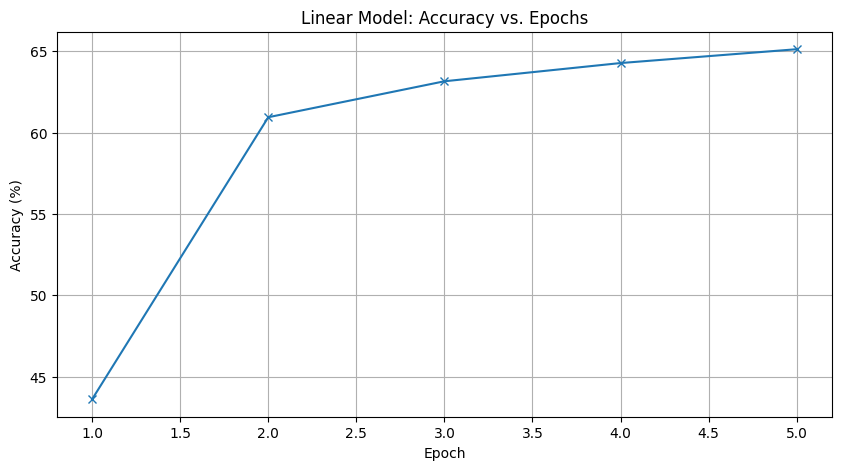

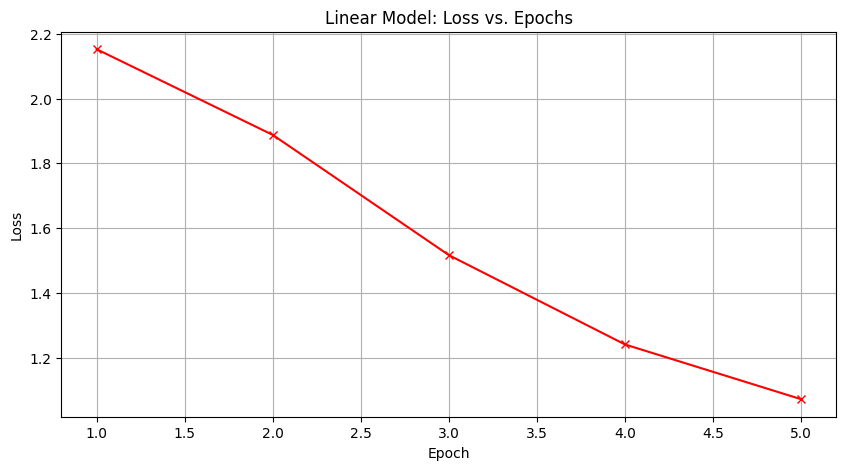

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in accuracy_h], marker='x')
plt.title('Linear Model: Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)') # Update the y-axis label to indicate percentage
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_h, marker='x', color='red')
plt.title('Linear Model: Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Simple CNN Model (4,8)
===============

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class SimpleCNN(nn.Module):
    def __init__(self, num_of_rows = 28, num_of_cols = 28,
                 n_filters1=4, n_filters2=8, out_categories=10):
        super().__init__()

        self.conv1 = nn.Conv2d(
                in_channels=1,            # 1 for grayscale
                out_channels=n_filters1,   # Number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )
        self.pool = nn.MaxPool2d(2, 2)  # halves size to 14x14

        self.conv2 = nn.Conv2d(
                in_channels=n_filters1,    # NOTE: Use n_filters1 from conv1
                out_channels=n_filters2,   # New number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )

        # out_categories should match the number of output categories.
        # Match the dimensions to the input.
        # Divide by 2 for each maxpooling (carefull for non-even numbers ...)
        num_of_pixels = math.ceil(num_of_rows/(2*2) * num_of_cols/(2*2))

        # Final layer collects the pixels from all of the inputs:
        self.fc1 = nn.Linear(n_filters2 * num_of_pixels, out_categories)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 4, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 8, 7, 7]
        x = x.view(x.size(0), -1)             # flatten to [batch, 8*7*7]
        logits = F.relu(self.fc1(x))
        return logits # Note: SoftMax is applied to logits by cross-entropy loss function.


## SimpleCNN
NeuralNetwork = SimpleCNN
model_to_use = SimpleCNN(n_filters1=4, n_filters2=8)

model = model_to_use.to(device)
print(f"Using Model: {model.__class__.__name__}") # Name of model print

Using cpu device
Using Model: SimpleCNN


## Model Parameters

In [ ]:
def parameter_report(model):
    print(f"{'Layer':<40} {'# Params':>12} {'Trainable':>10}")
    print("-" * 65)
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        is_trainable = param.requires_grad
        print(f"{name:<40} {num_params:>12,} {str(is_trainable):>10}")
        total += num_params
        if is_trainable:
            trainable += num_params
    print("-" * 65)
    print(f"{'Total':<40} {total:>12,} {'':>10}")
    print(f"{'Trainable':<40} {trainable:>12,}")


print(model)
print(" ")

parameter_report(model)

SimpleCNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=392, out_features=10, bias=True)
)
 
Layer                                        # Params  Trainable
-----------------------------------------------------------------
conv1.weight                                       36       True
conv1.bias                                          4       True
conv2.weight                                      288       True
conv2.bias                                          8       True
fc1.weight                                      3,920       True
fc1.bias                                           10       True
-----------------------------------------------------------------
Total                                           4,266           
Trainable                            

------------------------------------------------------------------------


## Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Training function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Put the model in training mode.
    for batch, (X, y) in enumerate(dataloader):
        # Place the model and predictions on the same device.
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        # This step updates the parameter values inside your network.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress every 100 batches:
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Testing function

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in testing mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

## Simple CNN: Accuracy, Epochs, and Value of Loss Function

In [ ]:
epochs = 5 # Number of epochs
accuracy_h = []
loss_h =[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    epoch_accuracy, epoch_loss = test(test_dataloader, model, loss_fn)
    accuracy_h.append(epoch_accuracy)
    loss_h.append(epoch_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301292  [   64/60000]
loss: 2.280095  [ 6464/60000]
loss: 2.268744  [12864/60000]
loss: 2.265154  [19264/60000]
loss: 2.244871  [25664/60000]
loss: 2.248159  [32064/60000]
loss: 2.200857  [38464/60000]
loss: 2.199050  [44864/60000]
loss: 2.173738  [51264/60000]
loss: 2.102298  [57664/60000]
Test Error: 
 Accuracy: 37.9%, Avg loss: 2.136511 

Test Error: 
 Accuracy: 37.9%, Avg loss: 2.136511 

Epoch 2
-------------------------------
loss: 2.137134  [   64/60000]
loss: 2.092418  [ 6464/60000]
loss: 2.025864  [12864/60000]
loss: 2.008314  [19264/60000]
loss: 1.897996  [25664/60000]
loss: 1.932949  [32064/60000]
loss: 1.772016  [38464/60000]
loss: 1.796497  [44864/60000]
loss: 1.805718  [51264/60000]
loss: 1.659309  [57664/60000]
Test Error: 
 Accuracy: 41.6%, Avg loss: 1.742512 

Test Error: 
 Accuracy: 41.6%, Avg loss: 1.742512 

Epoch 3
-------------------------------
loss: 1.749854  [   64/60000]
loss: 1.723446  [ 6464/60000]
loss: 1.6144

## Plot

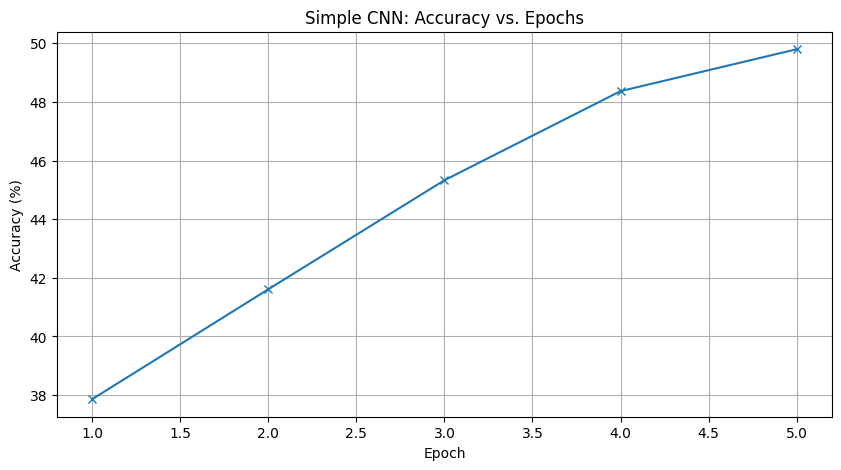

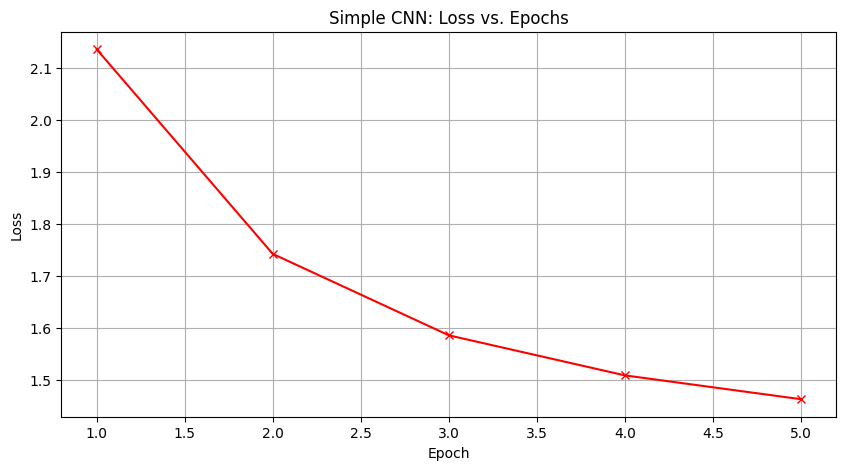

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in accuracy_h], marker='x')
plt.title('Simple CNN: Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)') # Update the y-axis label to indicate percentage
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_h, marker='x', color='red')
plt.title('Simple CNN: Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

------------------------------------------------------------------------


CNN Model 2 - Filters Change (8,16)
===============

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class SimpleCNN(nn.Module):
    def __init__(self, num_of_rows = 28, num_of_cols = 28,
                 n_filters1=8, n_filters2=16, out_categories=10):
        super().__init__()

        self.conv1 = nn.Conv2d(
                in_channels=1,            # 1 for grayscale
                out_channels=n_filters1,   # Number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )
        self.pool = nn.MaxPool2d(2, 2)  # halves size to 14x14

        self.conv2 = nn.Conv2d(
                in_channels=n_filters1,    # NOTE: Use n_filters1 from conv1
                out_channels=n_filters2,   # New number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )

        # out_categories should match the number of output categories.
        # Match the dimensions to the input.
        # Divide by 2 for each maxpooling (carefull for non-even numbers ...)
        num_of_pixels = math.ceil(num_of_rows/(2*2) * num_of_cols/(2*2))

        # Final layer collects the pixels from all of the inputs:
        self.fc1 = nn.Linear(n_filters2 * num_of_pixels, out_categories)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 4, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 8, 7, 7]
        x = x.view(x.size(0), -1)             # flatten to [batch, 8*7*7]
        logits = F.relu(self.fc1(x))
        return logits # Note: SoftMax is applied to logits by cross-entropy loss function.


## SimpleCNN
NeuralNetwork = SimpleCNN
model_to_use = SimpleCNN(n_filters1=8, n_filters2=16)

model = model_to_use.to(device)
print(f"Using Model: {model.__class__.__name__}") # Name of model print

Using cpu device
Using Model: SimpleCNN


## Model Parameters

In [ ]:
def parameter_report(model):
    print(f"{'Layer':<40} {'# Params':>12} {'Trainable':>10}")
    print("-" * 65)
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        is_trainable = param.requires_grad
        print(f"{name:<40} {num_params:>12,} {str(is_trainable):>10}")
        total += num_params
        if is_trainable:
            trainable += num_params
    print("-" * 65)
    print(f"{'Total':<40} {total:>12,} {'':>10}")
    print(f"{'Trainable':<40} {trainable:>12,}")


print(model)
print(" ")

parameter_report(model)

SimpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)
 
Layer                                        # Params  Trainable
-----------------------------------------------------------------
conv1.weight                                       72       True
conv1.bias                                          8       True
conv2.weight                                    1,152       True
conv2.bias                                         16       True
fc1.weight                                      7,840       True
fc1.bias                                           10       True
-----------------------------------------------------------------
Total                                           9,098           
Trainable                           

------------------------------------------------------------------------


## Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Training function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Put the model in training mode.
    for batch, (X, y) in enumerate(dataloader):
        # Place the model and predictions on the same device.
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        # This step updates the parameter values inside your network.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress every 100 batches:
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Testing function

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in testing mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

## CNN Model 2 - Filters Change (8,16): Accuracy, Epochs, and Value of Loss Function

In [ ]:
epochs = 5 # Number of epochs
accuracy_h = []
loss_h =[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    epoch_accuracy, epoch_loss = test(test_dataloader, model, loss_fn)
    accuracy_h.append(epoch_accuracy)
    loss_h.append(epoch_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.313343  [   64/60000]
loss: 2.307346  [ 6464/60000]
loss: 2.292767  [12864/60000]
loss: 2.277751  [19264/60000]
loss: 2.266972  [25664/60000]
loss: 2.242071  [32064/60000]
loss: 2.196502  [38464/60000]
loss: 2.178524  [44864/60000]
loss: 2.142699  [51264/60000]
loss: 2.124562  [57664/60000]
Test Error: 
 Accuracy: 36.8%, Avg loss: 2.138719 

Test Error: 
 Accuracy: 36.8%, Avg loss: 2.138719 

Epoch 2
-------------------------------
loss: 2.126293  [   64/60000]
loss: 2.150475  [ 6464/60000]
loss: 2.097845  [12864/60000]
loss: 2.064420  [19264/60000]
loss: 2.072552  [25664/60000]
loss: 1.983581  [32064/60000]
loss: 1.833083  [38464/60000]
loss: 1.809219  [44864/60000]
loss: 1.788811  [51264/60000]
loss: 1.808716  [57664/60000]
Test Error: 
 Accuracy: 44.2%, Avg loss: 1.821091 

Test Error: 
 Accuracy: 44.2%, Avg loss: 1.821091 

Epoch 3
-------------------------------
loss: 1.777157  [   64/60000]
loss: 1.869016  [ 6464/60000]
loss: 1.7895

## Plot

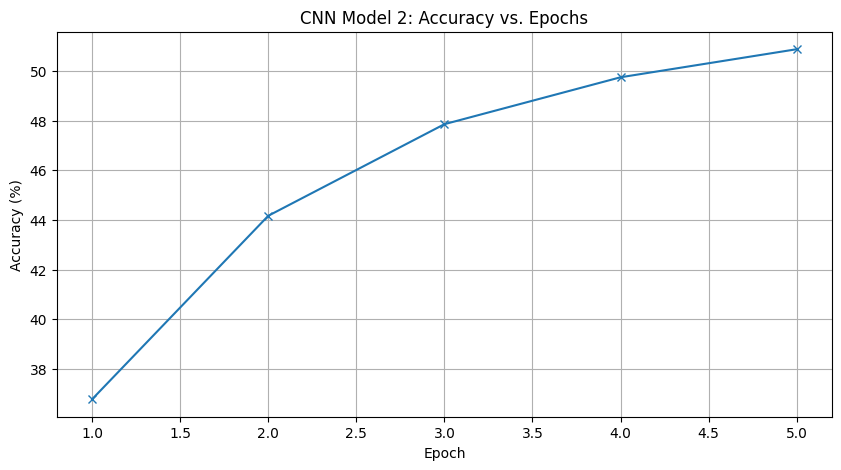

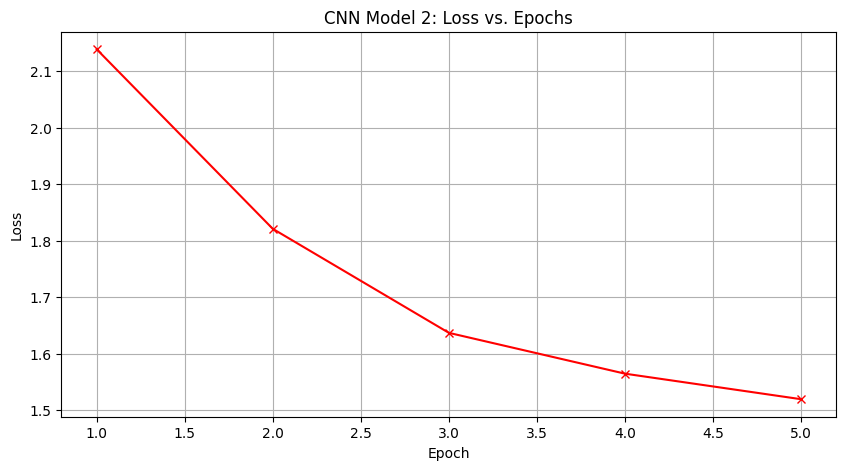

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in accuracy_h], marker='x')
plt.title('CNN Model 2: Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)') # Update the y-axis label to indicate percentage
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_h, marker='x', color='red')
plt.title('CNN Model 2: Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

------------------------------------------------------------------------


CNN Model 3 - Filters Change (16, 32)
===============

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class SimpleCNN(nn.Module):
    def __init__(self, num_of_rows = 28, num_of_cols = 28,
                 n_filters1=4, n_filters2=8, out_categories=10):
        super().__init__()

        self.conv1 = nn.Conv2d(
                in_channels=1,            # 1 for grayscale
                out_channels=n_filters1,   # Number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )
        self.pool = nn.MaxPool2d(2, 2)  # halves size to 14x14

        self.conv2 = nn.Conv2d(
                in_channels=n_filters1,    # NOTE: Use n_filters1 from conv1
                out_channels=n_filters2,   # New number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )

        # out_categories should match the number of output categories.
        # Match the dimensions to the input.
        # Divide by 2 for each maxpooling (carefull for non-even numbers ...)
        num_of_pixels = math.ceil(num_of_rows/(2*2) * num_of_cols/(2*2))

        # Final layer collects the pixels from all of the inputs:
        self.fc1 = nn.Linear(n_filters2 * num_of_pixels, out_categories)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 4, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 8, 7, 7]
        x = x.view(x.size(0), -1)             # flatten to [batch, 8*7*7]
        logits = F.relu(self.fc1(x))
        return logits # Note: SoftMax is applied to logits by cross-entropy loss function.

# Define model
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Define the model here

## Linear Model
#NeuralNetwork = LinearModel
#model_to_use  = LinearModel()

## SimpleCNN
NeuralNetwork = SimpleCNN
model_to_use = SimpleCNN(n_filters1=16, n_filters2=32)

model = model_to_use.to(device)
print(f"Using Model: {model.__class__.__name__}") # Name of model print

Using cpu device
Using Model: SimpleCNN


## Model Parameters

In [ ]:
def parameter_report(model):
    print(f"{'Layer':<40} {'# Params':>12} {'Trainable':>10}")
    print("-" * 65)
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        is_trainable = param.requires_grad
        print(f"{name:<40} {num_params:>12,} {str(is_trainable):>10}")
        total += num_params
        if is_trainable:
            trainable += num_params
    print("-" * 65)
    print(f"{'Total':<40} {total:>12,} {'':>10}")
    print(f"{'Trainable':<40} {trainable:>12,}")


print(model)
print(" ")

parameter_report(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
 
Layer                                        # Params  Trainable
-----------------------------------------------------------------
conv1.weight                                      144       True
conv1.bias                                         16       True
conv2.weight                                    4,608       True
conv2.bias                                         32       True
fc1.weight                                     15,680       True
fc1.bias                                           10       True
-----------------------------------------------------------------
Total                                          20,490           
Trainable                        

------------------------------------------------------------------------


## Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Training function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Put the model in training mode.
    for batch, (X, y) in enumerate(dataloader):
        # Place the model and predictions on the same device.
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        # This step updates the parameter values inside your network.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress every 100 batches:
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Testing function

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in testing mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

## CNN Model 3 - Filters Change (16, 32): Accuracy, Epochs, and Value of Loss Function

In [ ]:
epochs = 5 # Number of epochs
accuracy_h = []
loss_h =[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    epoch_accuracy, epoch_loss = test(test_dataloader, model, loss_fn)
    accuracy_h.append(epoch_accuracy)
    loss_h.append(epoch_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299995  [   64/60000]
loss: 2.274200  [ 6464/60000]
loss: 2.252039  [12864/60000]
loss: 2.233598  [19264/60000]
loss: 2.200487  [25664/60000]
loss: 2.186034  [32064/60000]
loss: 2.059010  [38464/60000]
loss: 2.038870  [44864/60000]
loss: 1.926694  [51264/60000]
loss: 1.898028  [57664/60000]
Test Error: 
 Accuracy: 50.1%, Avg loss: 1.852023 

Test Error: 
 Accuracy: 50.1%, Avg loss: 1.852023 

Epoch 2
-------------------------------
loss: 1.848779  [   64/60000]
loss: 1.802843  [ 6464/60000]
loss: 1.712018  [12864/60000]
loss: 1.656991  [19264/60000]
loss: 1.656756  [25664/60000]
loss: 1.751615  [32064/60000]
loss: 1.420980  [38464/60000]
loss: 1.478610  [44864/60000]
loss: 1.408488  [51264/60000]
loss: 1.542449  [57664/60000]
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.409900 

Test Error: 
 Accuracy: 56.9%, Avg loss: 1.409900 

Epoch 3
-------------------------------
loss: 1.403184  [   64/60000]
loss: 1.434032  [ 6464/60000]
loss: 1.3212

## Plot

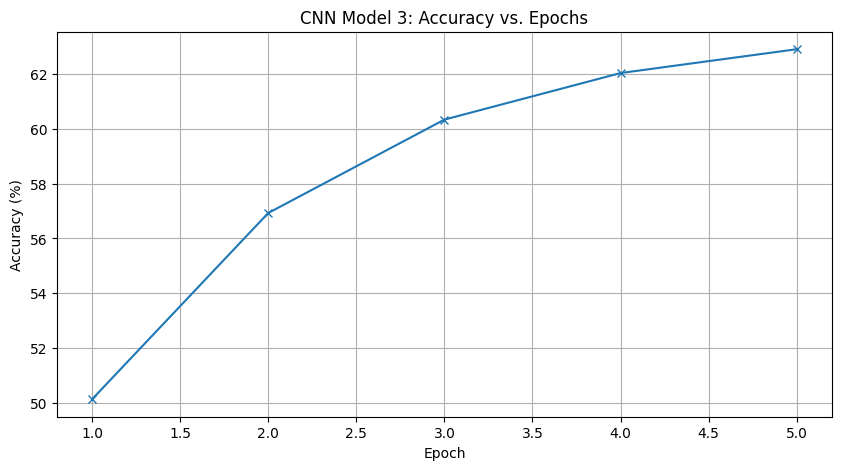

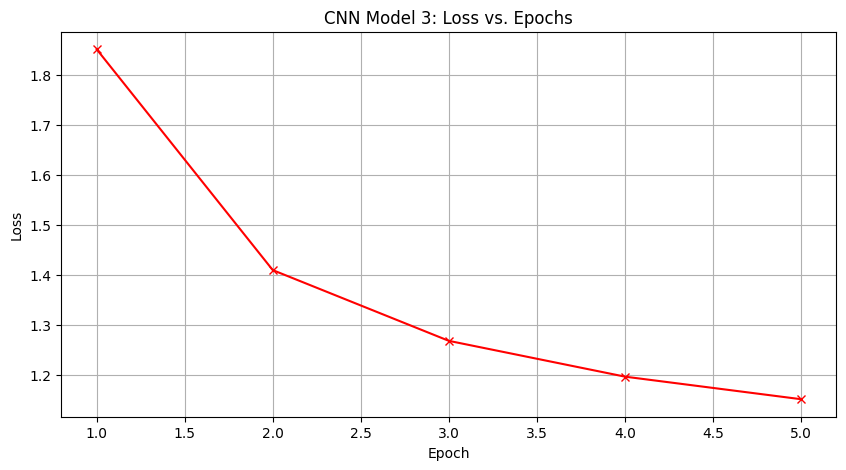

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in accuracy_h], marker='x')
plt.title('CNN Model 3: Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)') # Update the y-axis label to indicate percentage
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_h, marker='x', color='red')
plt.title('CNN Model 3: Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

------------------------------------------------------------------------
